Dataset Shape: (918, 12)

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
--

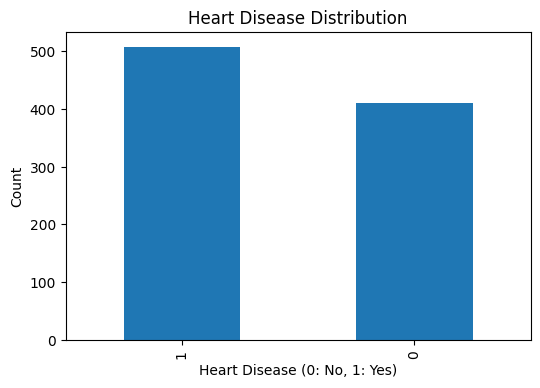


========== DATA PREPROCESSING ==========
Replaced 0 values in Cholesterol with mean: 244.64
Replaced 0 values in RestingBP with mean: 132.54


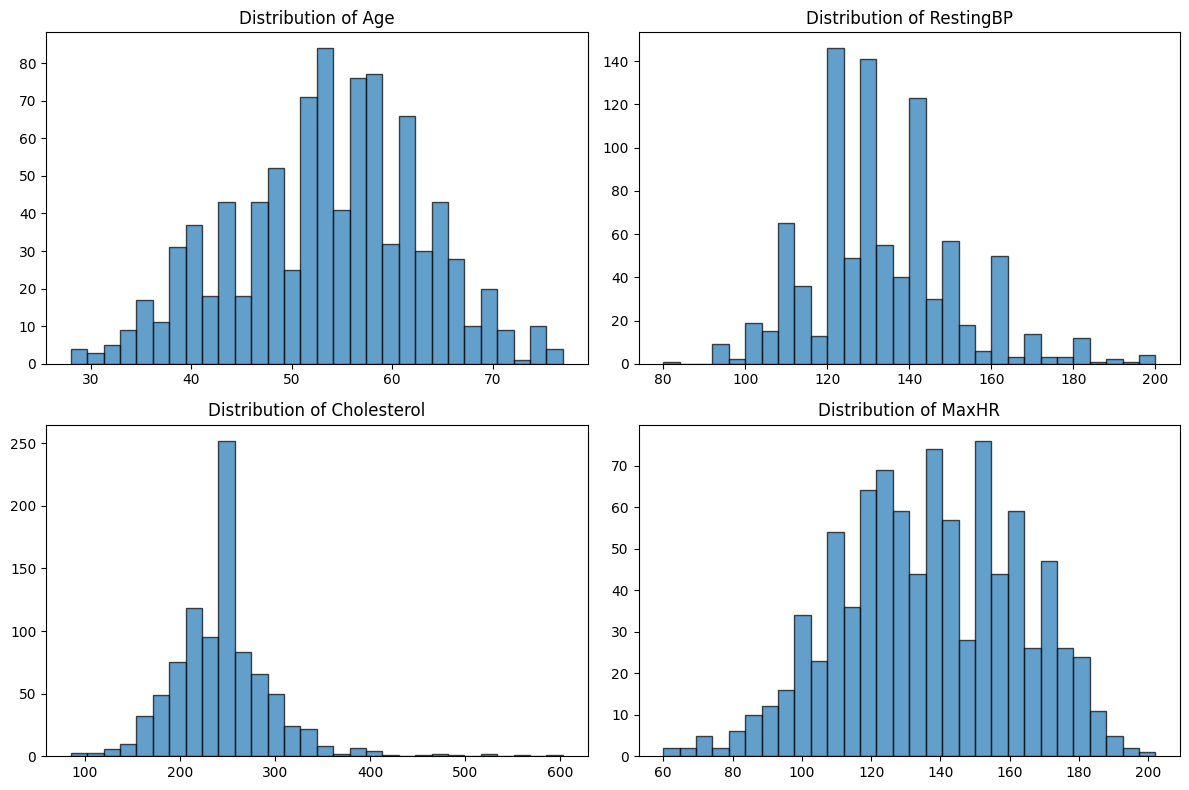

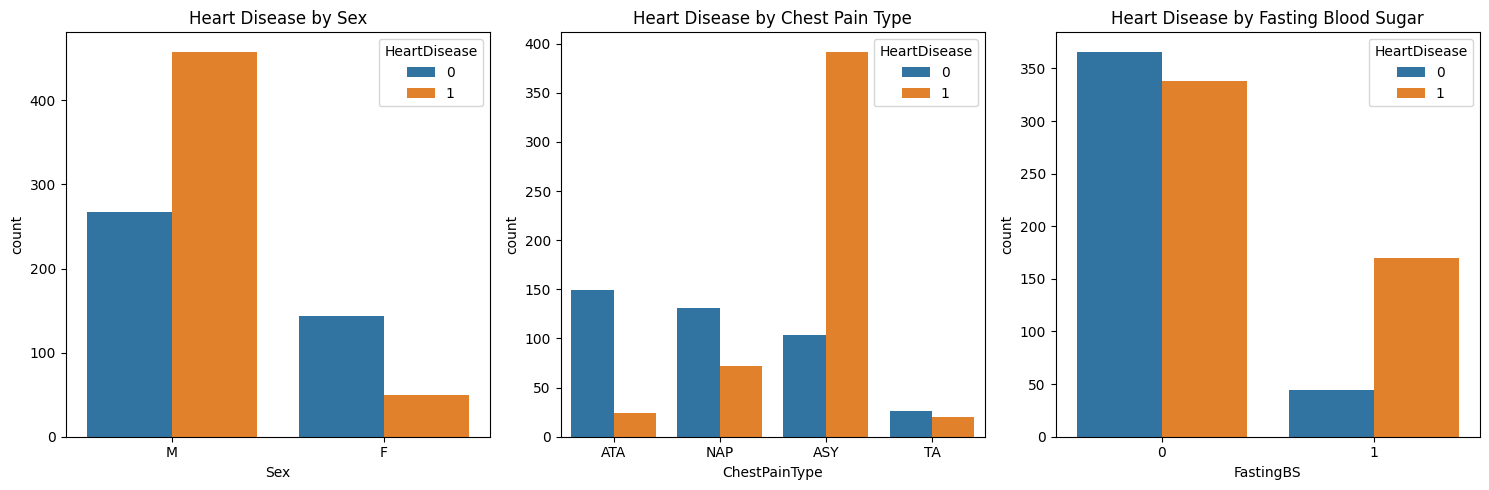

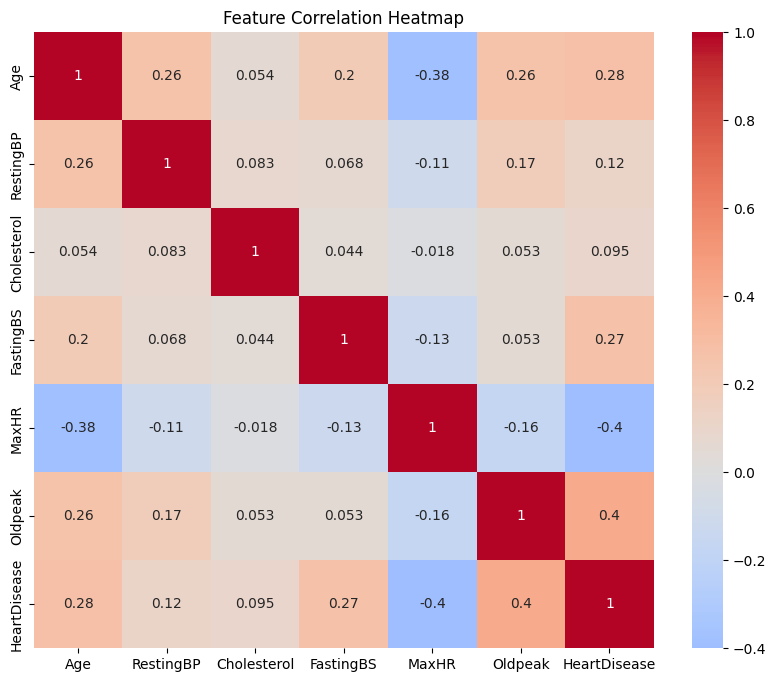

Encoded Sex: {'F': np.int64(0), 'M': np.int64(1)}
Encoded ChestPainType: {'ASY': np.int64(0), 'ATA': np.int64(1), 'NAP': np.int64(2), 'TA': np.int64(3)}
Encoded RestingECG: {'LVH': np.int64(0), 'Normal': np.int64(1), 'ST': np.int64(2)}
Encoded ExerciseAngina: {'N': np.int64(0), 'Y': np.int64(1)}
Encoded ST_Slope: {'Down': np.int64(0), 'Flat': np.int64(1), 'Up': np.int64(2)}

Selected 9 features based on correlation threshold

Training set size: (734, 9)
Test set size: (184, 9)

Features scaled using StandardScaler

========== RANDOM FOREST MODEL TRAINING ==========

Random Forest Accuracy: 0.8587

Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.85      0.83      0.84        82
   Heart Disease       0.87      0.88      0.87       102

        accuracy                           0.86       184
       macro avg       0.86      0.86      0.86       184
    weighted avg       0.86      0.86      0.86       184



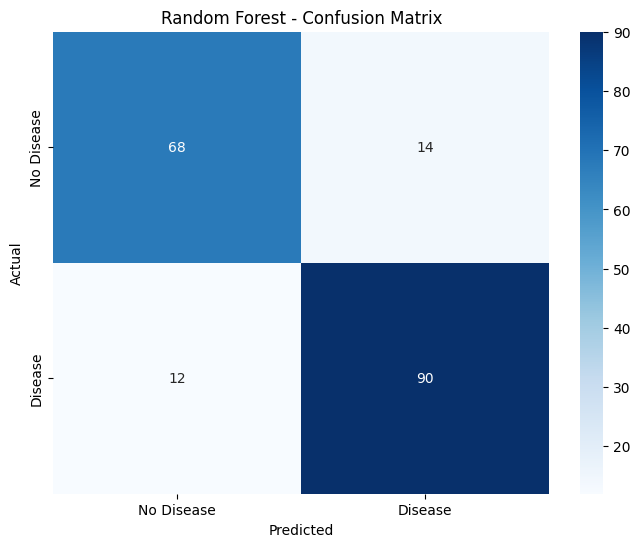


Top 10 Most Important Features:
          feature  importance
8        ST_Slope    0.256624
7           MaxHR    0.145188
1         Oldpeak    0.130268
6   ChestPainType    0.126823
3             Age    0.097125
0  ExerciseAngina    0.093417
5       RestingBP    0.082819
2             Sex    0.037551
4       FastingBS    0.030185


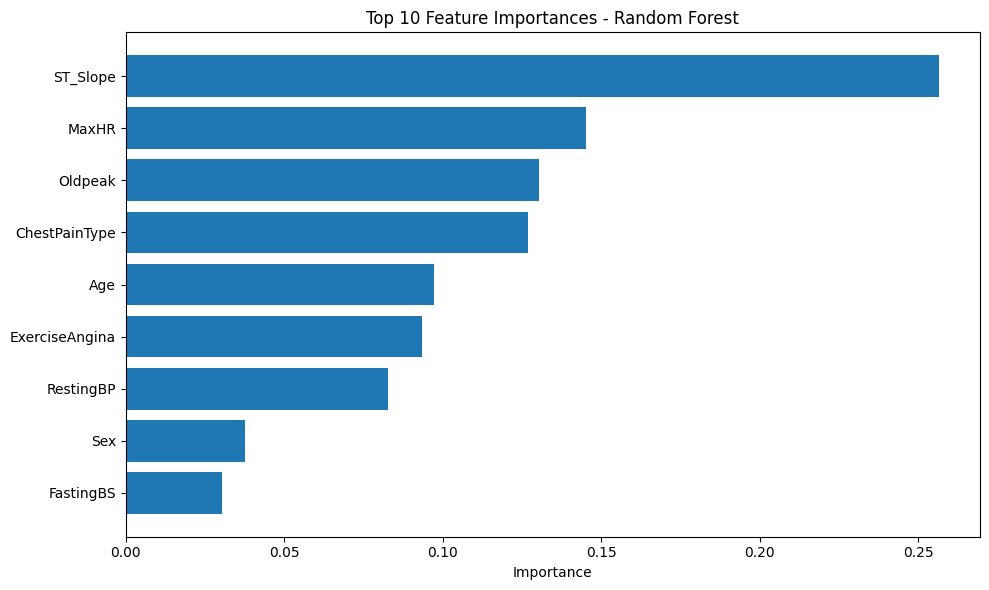


✓ Model and preprocessing objects saved


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pickle
import warnings

warnings.filterwarnings('ignore')

# ==================== DATA LOADING ====================
df = pd.read_csv('heart.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# ==================== DATA EXPLORATION ====================
print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nDuplicate Rows:", df.duplicated().sum())
print("Missing Values:\n", df.isnull().sum())

# Visualize target distribution
plt.figure(figsize=(6, 4))
df['HeartDisease'].value_counts().plot(kind='bar')
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# ==================== DATA PREPROCESSING ====================
print("\n========== DATA PREPROCESSING ==========")

# Handle zero values in Cholesterol
ch_mean = df.loc[df['Cholesterol'] != 0, 'Cholesterol'].mean()
df['Cholesterol'] = df['Cholesterol'].replace(0, ch_mean).round()
print(f"Replaced 0 values in Cholesterol with mean: {ch_mean:.2f}")

# Handle zero values in RestingBP
resting_bp_mean = df.loc[df['RestingBP'] != 0, 'RestingBP'].mean()
df['RestingBP'] = df['RestingBP'].replace(0, resting_bp_mean).round(2)
print(f"Replaced 0 values in RestingBP with mean: {resting_bp_mean:.2f}")

# ==================== EDA (Optional visuals) ====================
# Numeric distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for idx, feature in enumerate(['Age', 'RestingBP', 'Cholesterol', 'MaxHR']):
    axes[idx].hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Categorical feature analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x='Sex', hue='HeartDisease', data=df, ax=axes[0])
axes[0].set_title('Heart Disease by Sex')
sns.countplot(x='ChestPainType', hue='HeartDisease', data=df, ax=axes[1])
axes[1].set_title('Heart Disease by Chest Pain Type')
sns.countplot(x='FastingBS', hue='HeartDisease', data=df, ax=axes[2])
axes[2].set_title('Heart Disease by Fasting Blood Sugar')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

# ==================== LABEL ENCODING ====================
label_encoders = {}
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

df_encoded = df.copy()
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# ==================== FEATURE SELECTION ====================
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

corr_with_target = X.corrwith(y).sort_values(ascending=False)
selected_features = corr_with_target[abs(corr_with_target) > 0.1].index.tolist()
print(f"\nSelected {len(selected_features)} features based on correlation threshold")

X_selected = X[selected_features]

# ==================== TRAIN-TEST SPLIT ====================
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.20, random_state=42, stratify=y
)
print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# ==================== SCALING ====================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nFeatures scaled using StandardScaler")

# ==================== MODEL TRAINING & EVALUATION ====================
print("\n========== RANDOM FOREST MODEL TRAINING ==========")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Heart Disease', 'Heart Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ==================== SAVE MODEL & PREPROCESSING OBJECTS ====================
with open('random_forest_heart_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("\n✓ Model and preprocessing objects saved")
